In [1]:
#hide
from utils import *
from fastai2.vision.widgets import *

## Resident Evil Character Detector

Using bing image search I downloaded the different characters from the resident evil series monsters which I will use to train a resident evil character detection

In [2]:
key = 'XXXX'

In [3]:
monsters = 't-type nemesis','licker','hunter','zombie'
path = Path('/storage/resident_evil/monsters')

This code will perform a search of the different monsters and download each under the folder names used for labeling later in the modeling

In [ ]:
if not path.exists():
    path.mkdir()
    for o in monsters:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'resident evil {o}')
        download_images(dest, urls=results.attrgot('content_url'))

### Data preprocessing
As part of the download we will start by cleaning up and validating out images the get_image_files() function is used for obtaining the image path and the we will execute the verify images to make sure remove all the images with issues

In [4]:
fns = get_image_files(path) # Returns a list of file names with paths
failed = verify_images(fns) # Function will find images that cant be opened
failed

(#0) []

In [5]:
failed.map(Path.unlink);

### Datablock Generation
Using the data block API we will generate a new type of block that will use a single category and is using images for the data, we will obtain items using the get_image_files function and split the validation dataset to a .3 percent, the label data will be obtained via the parent folder and we will resize images to 224


In [6]:
monsters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128))

In [33]:
dls = monsters.dataloaders(path)

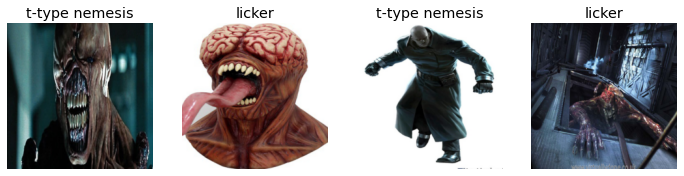

In [34]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# # Resize Images using Squishing
# monsters = monsters.new(
#     item_tfms=Resize(128, 
#                      ResizeMethod.Squish))
# dls = monsters.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)


# # Resize Images using Padding 
# monsters = monsters.new(
#     item_tfms=Resize(128, 
#                      ResizeMethod.Pad, 
#                      pad_mode='zeros'))

# dls = monsters.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

### Training the model
We will create a new model using the dataset and then we will perform a clean up using the image classifier cleaner 

In [48]:
monsters = monsters.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = monsters.dataloaders(path)

In [49]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.025483,1.172888,0.445860,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.200213,0.811476,0.337580,00:10
1,0.964967,0.595568,0.216561,00:09
2,0.798865,0.475194,0.178344,00:09
3,0.655921,0.442501,0.165605,00:09


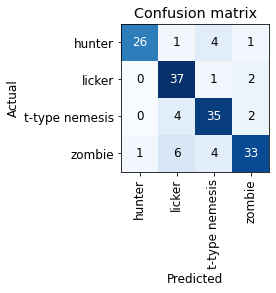

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

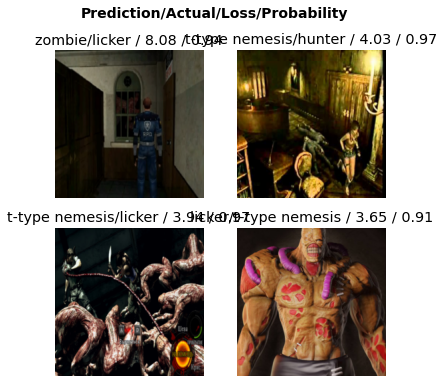

In [51]:
interp.plot_top_losses(4, nrows=2)

### Image Cleaning
We will perform an image cleaning process were we will review the images of the data set and use that for re training out model this will enable us to create a and fine tune our model and our data

#### Important
The next cleaning process is done in 2 steps:

1. Use the cleaning widget and select the correct action to perfom on the images
1. Execute the function below the cleaner since that will be used to actually remove the images

In [61]:
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: name 'ImageCleaner' is not defined

In [45]:

#Remove files marked for delete
# for idx in cleaner.delete(): 
#     print(cleaner.fns[idx])
#     cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): 
#     shutil.copyfile(cleaner.fns[idx], path/cat)

/storage/resident_evil/monsters/zombie/00000117.jpg
/storage/resident_evil/monsters/zombie/00000061.jpg
/storage/resident_evil/monsters/zombie/00000033.jpg
/storage/resident_evil/monsters/zombie/00000045.jpg
/storage/resident_evil/monsters/zombie/00000009.jpg


### Testing and Production 
The next sections will be focused for testing the model and exporting it for production use

### Using the model for inference
The model will be used for inference testing and then we will used the exported pkl file for creating the final production app

In [63]:
learn.export()

In [64]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [65]:
learn_inf = load_learner(path/'export.pkl')

In [56]:
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [57]:
img = PILImage.create(btn_upload.data[-1])

Output()

In [66]:
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: t-type nemesis; Probability: 0.9934')

### Notebook application for Classification
The next set of functions are used to use our model and classify it using the exported production version

In [72]:
### classification btn
btn_run = widgets.Button(description='Classify')


### Function to classify images when the btn is pressed
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

### Attach function to onclick event for the javascript btn
btn_run.on_click(on_click_classify)

#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [71]:
### Widget definition where we are selecting an image and then using it for prediction
VBox([widgets.Label('Detect RE Monster'), 
      btn_upload, btn_run, out_pl, lbl_pred])